# Transverse field Ising model to demo primitives

In [3]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate

SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

In [4]:

def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0,trotter_barriers = False, layer_barriers = False):
    
    if num_cl_bits == 0:
        qc= QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    for trotter_steps in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:    
            qc.barrier()

    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i, i + 1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i + 1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()    

    # adding Rzz in the odd layers
    for i in range(1, qc.num_qubits - 1, 2):
        qc.sdg([i, i + 1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i + 1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    qc.rx(rx_angle, list(range(qc.num_qubits)))     
    if layer_barriers:
        qc.barrier()

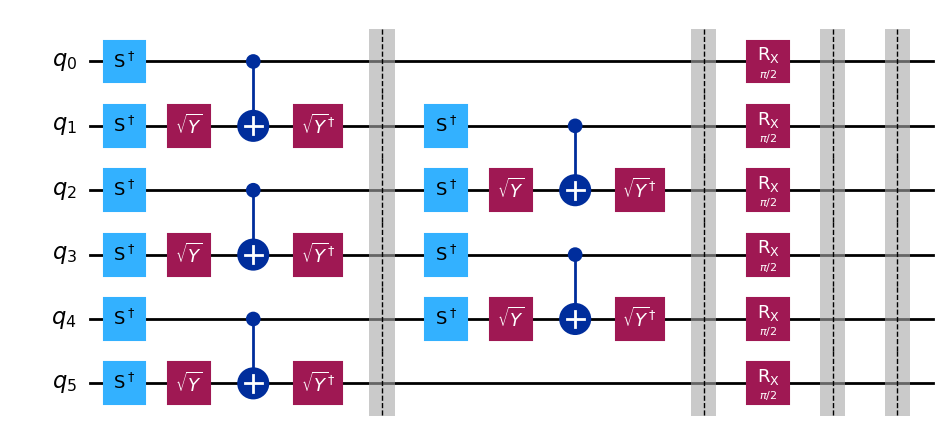

In [5]:

#num_cl_bits = 0  # Number of classical bits for measurement
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw (output='mpl', fold=-1)

# Demo Sampler

In [6]:
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):

    for trotter_steps in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:    
            qc.barrier()

    return qc

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))     
    if layer_barriers:
        qc.barrier()

    # adding Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])    
        
    if layer_barriers:
        qc.barrier()    

    # adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])    
        
    if layer_barriers:
        qc.barrier()    

    
    

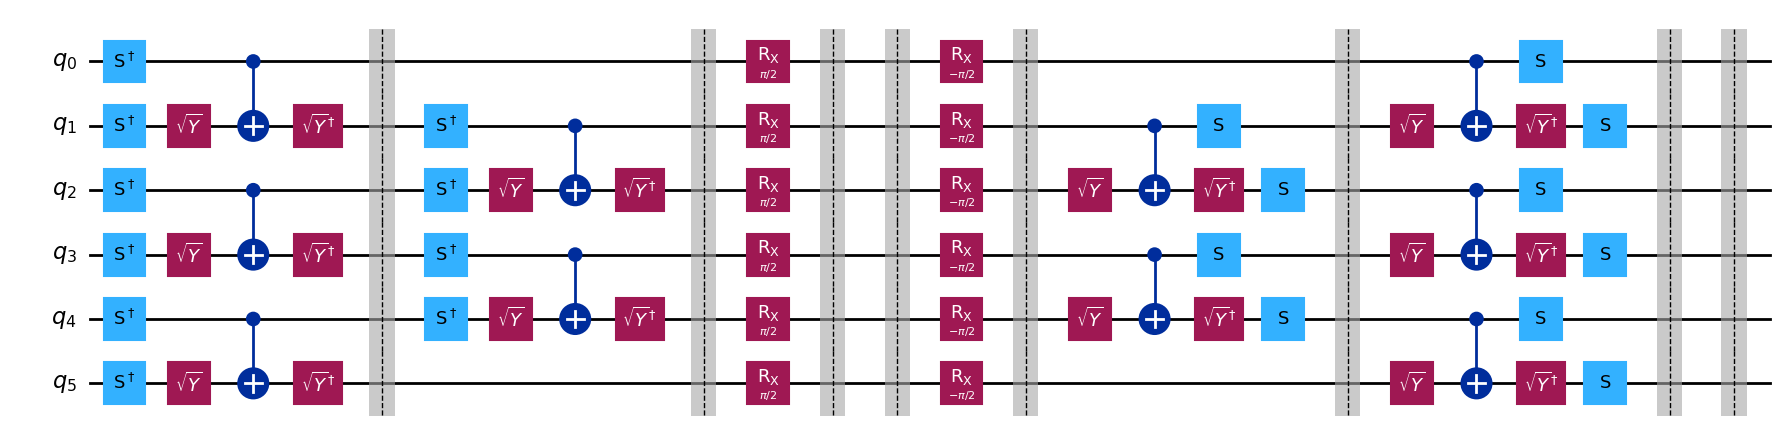

In [7]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw (output='mpl', fold=-1)

# Step 1: Map the problem to circuits and observables  

In [9]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49,50]

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc=generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle,num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

    


# Step 2: Optimize


In [10]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name='ibm_brisbane'
service= QiskitRuntimeService()
backend = service.backend(backend_name)
print("Done, getting the backend")

qc_transpiled_list=transpile(qc_list, backend=backend, optimization_level=1)

/var/folders/4z/26qvd6sn2q3349675r3f8qh80000gp/T/ipykernel_1623/1832820571.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service= QiskitRuntimeService()


Done, getting the backend


# Step 3: Execute on Quantum hardware

In [11]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'

job = sampler.run(qc_transpiled_list)
print(job.job_id())

d1g6kk6n2txg008ev0cg


/Users/satya/cwq/miniconda3/envs/cwq/lib/python3.13/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


# Step 4: Post processing and plotting

In [18]:
job_id = "d1g6kk6n2txg008ev0cg"  # Replace with your actual job ID
service = QiskitRuntimeService()
job = service.job(job_id)

survival_probability_list= []
for trotter_steps in range(max_trotter_steps):
    try:
        data = job.result()[trotter_steps].data
        counts = data.c.get_counts()
        survival_probability_list.append(counts.get('0'*len(measured_qubits), 0) / data.c.num_shots)
    except:
        survival_probability_list.append(0)
        print(job.job_id())



/var/folders/4z/26qvd6sn2q3349675r3f8qh80000gp/T/ipykernel_1623/895907694.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


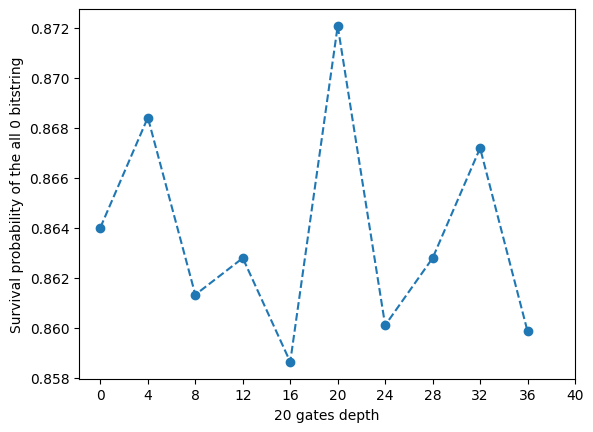

In [19]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('20 gates depth')
plt.ylabel('Survival probability of the all 0 bitstring')
plt.xticks(np.arange(0, 44, 4))
plt.show()

# Estimator

# Step 1: Mapping the Problem

In [21]:
from qiskit.circuit import Parameter
rx_angle = Parameter('rx_angle')
trotter_steps = 2
qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits // 2
observable = SparsePauliOp("I" * middle_index + "Z" + "I" * (num_qubits - middle_index - 1))

# Step 2: Optimize the circuit

In [22]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.backend(backend_name)

qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
observable =observable.apply_layout(qc_transpiled.layout)

/var/folders/4z/26qvd6sn2q3349675r3f8qh80000gp/T/ipykernel_1623/2109355622.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


# Step 3: Execute on Quantum Hardware

In [ ]:
from qiskit_ibm_runtime import EstimatorOptions, EstimatorV2

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'

estimator = EstimatorV2(backend=backend, options=options)
job = estimator.run(qc_transpiled, observable, rx_angle_list)
print(job.job_id())

